In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')'''

Mounted at /content/gdrive


In [ ]:
'''
import os
path="/content/gdrive/My Drive"
os.chdir(path)
os.listdir(path)'''

['net_config (6).cpython-37.pyc',
 '.ipynb_checkpoints',
 'net_config (5).cpython-37.pyc',
 'EnsembleModel (1).cpython-37.pyc',
 'net_config (4).cpython-37.pyc',
 'EnsembleModel.cpython-37.pyc',
 'net_config (3).cpython-37.pyc',
 'seqGAN',
 'ML_dialogue',
 'seqGAN_tran.ipynb',
 '6000J',
 '5002',
 '5012',
 'exam5003',
 'net_config (2).cpython-37.pyc',
 'MultiLabelTextClassification',
 'net_config (1).cpython-37.pyc',
 'net_config.cpython-37.pyc',
 'MAAL.ipynb',
 '5002final',
 'MSBD5002_Fall2021_Final_Data',
 'processed_text.csv']

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
import datetime
from dateutil.parser import parse 
import pytz 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score ,roc_curve, auc, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
import csv

In [ ]:
data=pd.read_csv("MSBD5002_Fall2021_Final_Data/Q3/train_valid.csv",header=None,sep=',')

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,0.709804,0.686275,0.584314,0.501961,0.478431,0.549020,0.525490,0.556863,0.580392,0.572549,0.603922,0.607843,0.549020,0.615686,0.560784,0.541176,0.533333,0.541176,0.596078,0.584314,0.482353,0.027451,0.027451,1.341476e-63,0.023529,1.064162e-83,0.419608,0.890196,0.721569,0.584314,0.458824,0.478431,0.576471,0.513725,0.513725,0.552941,0.572549,0.552941,0.576471,0.596078,...,0.266667,0.286275,0.298039,0.317647,0.349020,0.325490,0.372549,0.411765,0.423529,0.474510,0.858824,0.352941,0.415686,0.423529,0.470588,0.568627,0.576471,0.517647,0.325490,0.152941,0.156863,0.231373,0.235294,0.203922,0.223529,0.266667,0.266667,0.250980,0.278431,0.305882,0.301961,0.301961,0.329412,0.380392,0.419608,0.368627,0.368627,0.498039,0.909804,0.0
1,0.333333,0.317647,0.301961,0.317647,0.482353,0.400000,0.258824,0.356863,0.635294,0.615686,0.290196,0.050980,0.101961,0.035294,0.101961,0.125490,0.317647,0.450980,0.352941,0.494118,0.498039,0.541176,0.494118,5.568627e-01,0.580392,4.666667e-01,0.458824,0.517647,0.329412,0.321569,0.305882,0.317647,0.439216,0.290196,0.403922,0.184314,0.407843,0.600000,0.066667,0.078431,...,0.149020,0.337255,0.501961,0.427451,0.415686,0.541176,0.498039,0.223529,0.145098,0.203922,0.133333,0.588235,0.607843,0.486275,0.439216,0.462745,0.596078,0.400000,0.145098,0.211765,0.266667,0.152941,0.082353,0.047059,0.066667,0.074510,0.062745,0.066667,0.109804,0.227451,0.352941,0.419608,0.490196,0.533333,0.564706,0.490196,0.247059,0.184314,0.384314,0.0
2,0.788235,0.984314,0.952941,0.960784,0.529412,0.160784,0.203922,0.211765,0.172549,0.270588,0.207843,0.407843,0.772549,0.996078,0.968627,0.862745,0.980392,0.996078,0.894118,0.937255,0.945098,0.949020,0.949020,9.411765e-01,0.937255,9.411765e-01,0.949020,0.956863,0.901961,0.925490,0.972549,0.890196,0.913725,0.388235,0.156863,0.192157,0.129412,0.227451,0.219608,0.239216,...,0.909804,0.882353,0.909804,0.949020,0.929412,0.901961,0.925490,0.913725,0.878431,0.874510,0.917647,0.882353,0.878431,0.870588,0.862745,0.894118,0.701961,0.623529,0.815686,0.835294,0.733333,0.796078,0.878431,0.823529,0.874510,0.901961,0.913725,0.905882,0.866667,0.929412,0.929412,0.925490,0.866667,0.850980,0.913725,0.933333,0.921569,0.952941,0.921569,0.0
3,0.478431,0.490196,0.427451,0.513725,0.329412,0.478431,0.509804,0.384314,0.298039,0.470588,0.439216,0.372549,0.415686,0.411765,0.356863,0.356863,0.415686,0.447059,0.423529,0.427451,0.439216,0.443137,0.396078,3.529412e-01,0.368627,3.764706e-01,0.341176,0.498039,0.513725,0.411765,0.415686,0.517647,0.372549,0.478431,0.482353,0.415686,0.337255,0.462745,0.427451,0.384314,...,0.592157,0.749020,0.921569,0.992157,0.862745,0.843137,1.000000,0.839216,0.682353,0.450980,0.470588,0.400000,0.937255,0.854902,0.588235,0.447059,0.415686,0.513725,0.549020,0.505882,0.458824,0.423529,0.466667,0.470588,0.482353,0.376471,0.380392,0.494118,0.431373,0.317647,0.498039,0.568627,0.772549,0.925490,0.882353,0.862745,0.843137,0.474510,0.380392,0.0
4,0.152941,0.160784,0.172549,0.180392,0.184314,0.184314,0.184314,0.188235,0.196078,0.196078,0.180392,0.160784,0.137255,0.105882,0.705882,0.725490,0.564706,0.545098,0.266667,0.600000,0.337255,0.611765,0.650980,5.882353e-01,0.772549,5.843137e-01,0.407843,0.952941,0.133333,0.145098,0.152941,0.160784,0.164706,0.168627,0.168627,0.180392,0.192157,0.196078,0.176471,0.156863,...,0.086275,0.996078,0.933333,0.513725,0.709804,0.501961,0.447059,0.639216,0.690196,0.627451,0.549020,0.184314,0.196078,0.200000,0.203922,0.207843,0.219608,0.227451,0.211765,0.227451,0.227451,0.219608,0.219608,0.231373,0.227451,0.215686,0.164706,0.192157,0.145098,0.937255,0.945098,0.615686,0.611765,0.623529,0.662745,0.576471,0.576471,0.615686,0.501961,0.0


In [ ]:
label = {}
for i in range(len(data)):
    label[i] = data.iloc[i,-1]
distribution = {}
for i in label:
    if label[i] not in distribution:
       distribution[label[i]] = 1
    else:
       distribution[label[i]] += 1
distribution

{0.0: 1183,
 1.0: 1405,
 2.0: 1194,
 3.0: 1262,
 4.0: 1135,
 5.0: 962,
 6.0: 778,
 7.0: 600,
 8.0: 441,
 9.0: 309}

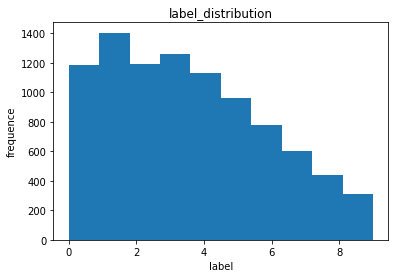

In [ ]:
plt.hist(data.iloc[:,-1], bins = 10)
plt.xlabel('label')
plt.ylabel('frequence')
plt.title('label_distribution')
plt.show()

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, x, y, test=False):
        self.x = x
        self.y = y
        self.test = test

    def __len__(self):
        return len(self.x)
  
    def __getitem__(self, idx):
        return self.x[idx,:,:], self.y[idx] if not self.test else self.x[idx,:,:]

In [ ]:
train_y.shape

(7415,)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.norm = nn.BatchNorm1d(400)
        self.L1 = nn.Linear(800, 400, bias=True)
        self.L2 = nn.Linear(800, 400, bias=True)
        self.L3 = nn.Linear(400, 10, bias=True)

        nn.init.xavier_normal(self.L1.weight)
        nn.init.xavier_normal(self.L2.weight)
        nn.init.xavier_normal(self.L3.weight)

    def forward(self, x):
        logits = self.pool(F.relu(self.conv1(x)))
        logits = self.pool(F.relu(self.conv2(logits)))
        logits = logits.reshape(-1, 800)
        logits = F.relu(self.L1(logits))
        logits = self.norm(logits)
        #logits = F.relu(self.L2(logits))
        logits = self.L3(logits)
        return logits

In [ ]:
def train(model, train_loader, optimizer,  criterion, device, batch_size):
    model.train()
    l = []
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = batch
        x = x.unsqueeze(1).float()
        y = y.long()
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        #print(logits.shape)
        loss = criterion(logits, y)
        l.append(loss.item())   
      
        loss.backward()
        optimizer.step()
    
    return np.mean(l)

def evaluation(model, val_loader, batch_size):
  preds = []
  probs = []
  y_list=[]
  for i,batch in enumerate(val_loader): 
      x, y = batch
      x = x.unsqueeze(1).float()
      y = y.long()
      x = x.to(device)
      #print(x.shape)
      y_list.append(y.numpy())
      with torch.no_grad():
        outputs = model(x)
        probabilities = F.softmax(outputs.cpu(), dim=1)
        _, pred = torch.max(probabilities, dim=1)
        probs.append(probabilities.tolist())
        preds.append(pred)
  return np.concatenate(preds,axis=0), np.concatenate(probs,axis=0), np.array([i for i in np.concatenate(y_list,axis=0)])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
batch_size = 256
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
model

CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (norm): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (L1): Linear(in_features=800, out_features=400, bias=True)
  (L2): Linear(in_features=800, out_features=400, bias=True)
  (L3): Linear(in_features=400, out_features=10, bias=True)
)

In [ ]:
y = data.iloc[:,-1].values
train_x, val_x, train_y, val_y = train_test_split(data.values[:,:-1],y,test_size=0.2,random_state=1)
train_x = train_x.reshape(train_x.shape[0], 28, 28)
val_x = val_x.reshape(val_x.shape[0], 28, 28)
train_dataset = ImageDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
val_dataset = ImageDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
count=0
for e in range(100):
  loss = train(model, train_loader, optimizer, criterion, device, batch_size)
  if e==0:
    last=loss
  else:
    pre=loss
    if (last-pre)/last <=0.01:
      count+=1
    if count==5:
      print("Final loss: %1.5f" % (loss))
      break
  if e % 5 == 0:
      print("Epoch: %d, loss: %1.5f" % (e, loss)) 

Epoch: 0, loss: 2.08573
Epoch: 5, loss: 1.21823
Epoch: 10, loss: 0.89108
Epoch: 15, loss: 0.65755
Epoch: 20, loss: 0.47346
Epoch: 25, loss: 0.31032
Epoch: 30, loss: 0.19155
Epoch: 35, loss: 0.11268
Epoch: 40, loss: 0.06506
Epoch: 45, loss: 0.04065
Epoch: 50, loss: 0.02822
Epoch: 55, loss: 0.02231
Epoch: 60, loss: 0.01852
Epoch: 65, loss: 0.01541
Epoch: 70, loss: 0.01342
Epoch: 75, loss: 0.01199
Epoch: 80, loss: 0.01079
Epoch: 85, loss: 0.01011
Epoch: 90, loss: 0.00964
Epoch: 95, loss: 0.00933


In [ ]:
preds, probs, y_true = evaluation(model, val_loader, batch_size)

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       242
           1       0.79      0.85      0.82       274
           2       0.61      0.58      0.59       239
           3       0.68      0.64      0.66       256
           4       0.58      0.62      0.60       239
           5       0.62      0.59      0.60       200
           6       0.53      0.49      0.51       143
           7       0.57      0.53      0.55       124
           8       0.43      0.40      0.42        82
           9       0.45      0.38      0.41        55

    accuracy                           0.64      1854
   macro avg       0.60      0.59      0.60      1854
weighted avg       0.64      0.64      0.64      1854



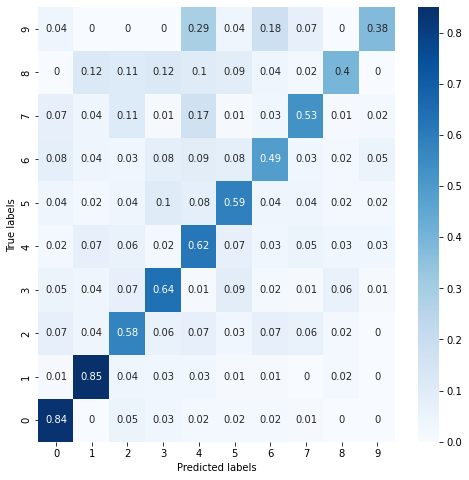

In [ ]:
import seaborn as sns
acc = accuracy_score(y_true, preds)
classification_report(y_true, preds)
 
 #peint calssification report
print(classification_report(y_true, preds))
 
 #build confusion matrix
con_mat = confusion_matrix(y_true, preds, labels=range(10))
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 10)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**Output**

In [ ]:
y.shape

(9269,)

In [ ]:
train = data.values[:,:-1].reshape(data.values[:,:-1].shape[0], 28, 28)

full_dataset = ImageDataset(train, y)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
preds, probs, y_true = evaluation(model, full_loader, batch_size)

In [ ]:
y_pred = pd.DataFrame(preds)
y_pred.to_csv('5002final/wjy/Q3_output.csv',header=False,index=False)